# AnyoneAI - Sprint Project 01
> E-Commerce Data Pipeline

In this notebook we will first execute all the components of our ELT pipeline and then plot visualizations with the resulting information.


In [1]:
# Importing the necessary libraries
from pandas import DataFrame
import pandas as pd
from sqlalchemy import create_engine
from typing import Dict
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from src.transform import QueryEnum
from src import config
from src.transform import run_queries
from src.extract import extract
from src.load import load
from src.plots import (
    plot_freight_value_weight_relationship,
    plot_global_amount_order_status,
    plot_real_vs_predicted_delivered_time,
    plot_revenue_by_month_year,
    plot_revenue_per_state,
    plot_top_10_least_revenue_categories,
    plot_top_10_revenue_categories,
    plot_top_10_revenue_categories_ammount,
    plot_delivery_date_difference,
    plot_order_amount_per_day_with_holidays,
)
from pandas import DataFrame, read_sql

In [2]:
# Create the database sql file
Path(config.SQLITE_BD_ABSOLUTE_PATH).touch()

# Create the database connection
ENGINE = create_engine(rf"sqlite:///{config.SQLITE_BD_ABSOLUTE_PATH}", echo=False)

### 1. Extract

Here you will be extracting the information from different sources.

In [3]:
csv_folder = config.DATASET_ROOT_PATH
public_holidays_url = config.PUBLIC_HOLIDAYS_URL

# 1. Get the mapping of the csv files to the table names.
csv_table_mapping = config.get_csv_to_table_mapping()


# 2. Extract the data from the csv files, holidays and load them into the dataframes.
csv_dataframes = extract(csv_folder, csv_table_mapping, public_holidays_url)

### 2. Load

Using the diferent datasets provided to you, you will store everything into our Data Warehouse.

In [4]:
load(data_frames=csv_dataframes, database=ENGINE)

### 3. Transform

Here you will be transforming the different queries into tables. There are two sections, one with the revenue related queries, and another with the delivery related queries.

##### 3.1 Revenue queries

In [5]:
csv_table_mapping

{'olist_customers_dataset.csv': 'olist_customers',
 'olist_geolocation_dataset.csv': 'olist_geolocation',
 'olist_order_items_dataset.csv': 'olist_order_items',
 'olist_order_payments_dataset.csv': 'olist_order_payments',
 'olist_order_reviews_dataset.csv': 'olist_order_reviews',
 'olist_orders_dataset.csv': 'olist_orders',
 'olist_products_dataset.csv': 'olist_products',
 'olist_sellers_dataset.csv': 'olist_sellers',
 'product_category_name_translation.csv': 'product_category_name_translation'}

In [7]:
query="SELECT order_status, COUNT(DISTINCT(order_id)) AS Ammount FROM olist_orders GROUP BY order_status"
result=read_sql(query, database)
result.head()#CAST(1235.53 AS INT)

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314


In [10]:
query_results: Dict[str, DataFrame] = run_queries(database=ENGINE)

/Users/karinaalem/Documents/anyone_ai/assignment/src/transform.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dates['date'] = filtered_dates['order_purchase_timestamp'].dt.date


In [11]:
# Transforming the revenue_by_month_year query to a table
revenue_by_month_year = query_results[QueryEnum.REVENUE_BY_MONTH_YEAR.value]
revenue_by_month_year

,month_no,month,Year2016,Year2017,Year2018
0,01,Jan,0.00,138488.04,1115004.18
1,02,Feb,0.00,291908.01,992463.34
2,03,Mar,0.00,449863.60,1159652.12
3,04,Apr,0.00,417788.03,1160785.48
4,05,May,0.00,592918.82,1153982.15
5,06,Jun,0.00,511276.38,1023880.50
6,07,Jul,0.00,592382.92,1066540.75
7,08,Aug,0.00,674396.32,1022425.32
8,09,Sep,252.24,727762.45,4439.54
9,10,Oct,59090.48,779677.88,589.67


In [12]:
# Transforming the top_10_revenue_categories query to a table
top_10_revenue_categories = query_results[QueryEnum.TOP_10_REVENUE_CATEGORIES.value]
top_10_revenue_categories

,Category,Num_order,Revenue
0,bed_bath_table,11650,1692714.28
1,health_beauty,9762,1620684.04
2,computers_accessories,7897,1549252.47
3,furniture_decor,8557,1394466.93
4,watches_gifts,6063,1387046.31
5,sports_leisure,8732,1349252.93
6,housewares,7172,1069787.97
7,auto,4283,833610.84
8,garden_tools,4464,810614.93
9,cool_stuff,3907,744649.32


In [13]:
# Transforming the top_10_least_revenue_categories query to a table
top_10_least_revenue_categories = query_results[
    QueryEnum.TOP_10_LEAST_REVENUE_CATEGORIES.value
]
top_10_least_revenue_categories

,Category,Num_order,Revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,718.98
2,cds_dvds_musicals,14,1199.43
3,home_comfort_2,31,1710.54
4,flowers,33,2213.01
5,arts_and_craftmanship,24,2326.17
6,la_cuisine,16,2913.53
7,fashion_sport,29,3605.83
8,diapers_and_hygiene,37,4126.17
9,fashio_female_clothing,45,4902.67


In [14]:
# Transforming the revenue_per_state query to a table
revenue_per_state = query_results[QueryEnum.REVENUE_PER_STATE.value]
revenue_per_state

,customer_state,Revenue
0,PI,1727.67
1,ES,393.46
2,AL,295.00
3,AC,225.42
4,PE,224.90
5,AP,216.26
6,GO,179.12
7,PR,175.26
8,MT,145.66
9,BA,141.46


##### 3.2 Delivery queries

In [15]:
# Transforming the delivery_date_difference query to a table
delivery_date_difference = query_results[QueryEnum.DELIVERY_DATE_DIFFERECE.value]
delivery_date_difference

,State,Delivery_Difference
0,AC,20
1,AL,8
2,AM,18
3,AP,19
4,BA,10
5,CE,10
6,DF,11
7,ES,9
8,GO,11
9,MA,8


In [16]:
# Transforming the real vs predicted delivered time query to a table per month and year
real_vs_estimated_delivered_time = query_results[
    QueryEnum.REAL_VS_ESTIMATED_DELIVERED_TIME.value
]
real_vs_estimated_delivered_time

,month_no,month,Year2016_real_time,Year2017_real_time,Year2018_real_time,Year2016_estimated_time,Year2017_estimated_time,Year2018_estimated_time
0,01,Jan,NaN,12.647044,14.080563,NaN,39.508831,26.302555
1,02,Feb,NaN,13.168825,16.945138,NaN,31.848929,24.528996
2,03,Mar,NaN,12.951184,16.301410,NaN,24.732386,22.033067
3,04,Apr,NaN,14.917913,11.499241,NaN,27.349810,23.679546
4,05,May,NaN,11.322363,11.419029,NaN,24.284784,22.891488
5,06,Jun,NaN,12.011573,9.239216,NaN,24.021864,27.772740
6,07,Jul,NaN,11.592732,8.958636,NaN,23.317316,19.690127
7,08,Aug,NaN,11.147125,7.732780,NaN,23.480603,15.186330
8,09,Sep,54.813194,11.851007,NaN,18.488449,22.437366,NaN
9,10,Oct,19.600559,11.856700,NaN,55.676632,23.019536,NaN


In [17]:
# Transforming the global ammount of order status query to a table
global_ammount_order_status = query_results[QueryEnum.GLOBAL_AMMOUNT_ORDER_STATUS.value]
global_ammount_order_status

,order_status,Ammount
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [18]:
orders_per_day_and_holidays = query_results[
    QueryEnum.ORDERS_PER_DAY_AND_HOLIDAYS_2017.value
]
orders_per_day_and_holidays

,order_count,date,holiday
0,32,2017-01-05,False
1,4,2017-01-06,False
2,4,2017-01-07,False
3,6,2017-01-08,False
4,5,2017-01-09,False
...,...,...,...
356,167,2017-12-27,False
357,146,2017-12-28,False
358,135,2017-12-29,False
359,97,2017-12-30,False


In [19]:
freight_value_weight_relationship = query_results[
    QueryEnum.GET_FREIGHT_VALUE_WEIGHT_RELATIONSHIP.value
]

### 4. Plotting the query tables

Now, we will create plots from the different queries

In [ ]:
plot_revenue_by_month_year(revenue_by_month_year, 2017)

In [20]:
plot_top_10_revenue_categories(top_10_revenue_categories)

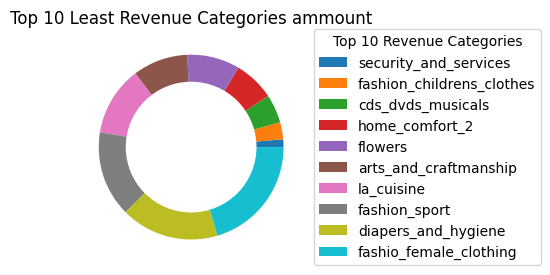

In [21]:
plot_top_10_least_revenue_categories(top_10_least_revenue_categories)

In [22]:
plot_revenue_per_state(revenue_per_state)

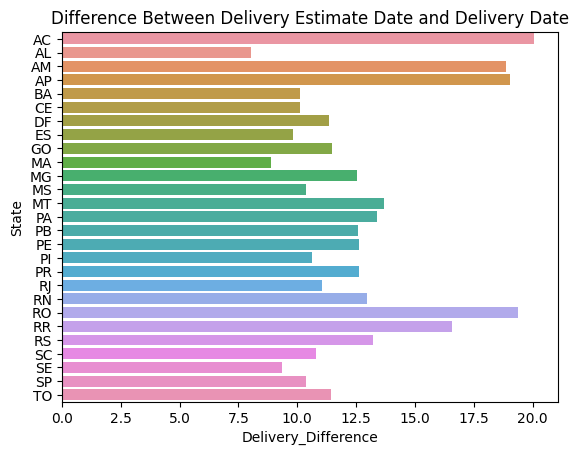

In [23]:
plot_delivery_date_difference(delivery_date_difference)

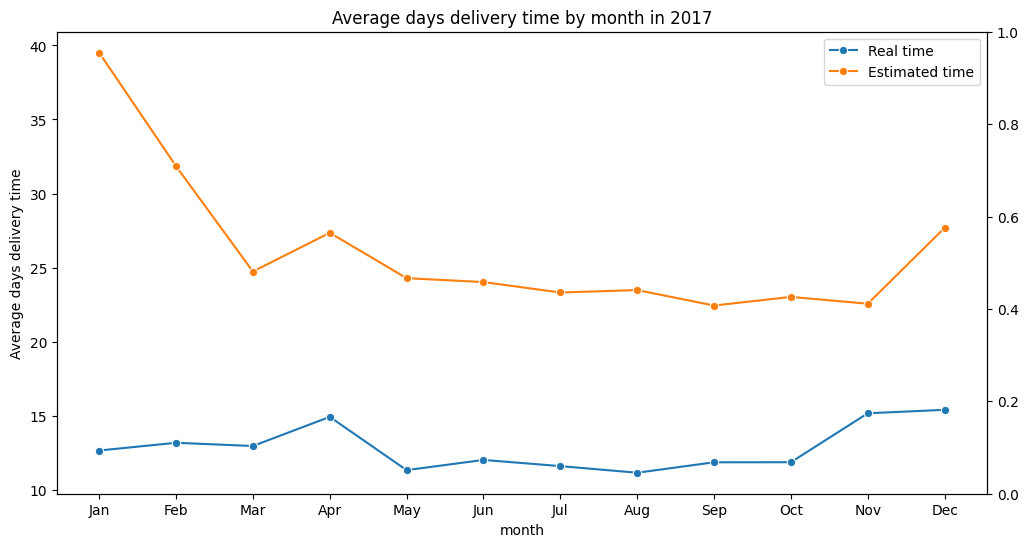

In [24]:
plot_real_vs_predicted_delivered_time(real_vs_estimated_delivered_time, year=2017)

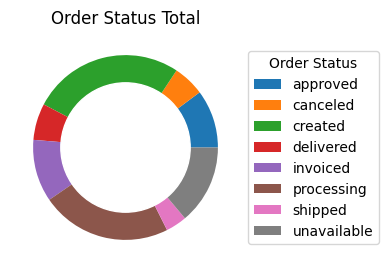

In [25]:
plot_global_amount_order_status(global_ammount_order_status)

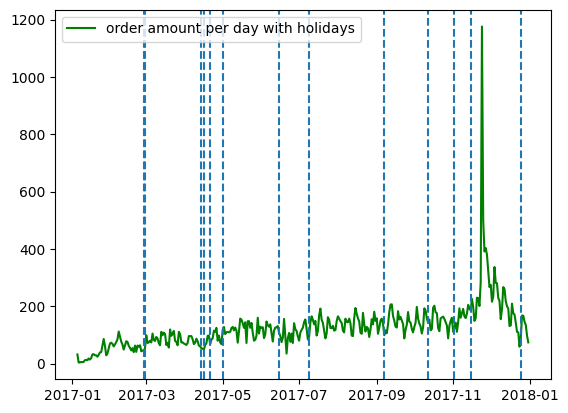

In [26]:
plot_order_amount_per_day_with_holidays(orders_per_day_and_holidays)

The Orders per Day and Holidays plot you will code in src/plots.py has to be similar to this:

![The plot you will code will be similar to this:](images/orders_per_day_and_holidays.png "Orders per Day and Holidays")

4.1 Do you see any relationship between the Brazilian public holidays of 2017 and that year's purchases?

#### There is a relationship. The holidays are not the days that sell the most except for May 2017. In the remaining 11 holidays it corresponds to a drop in sales.

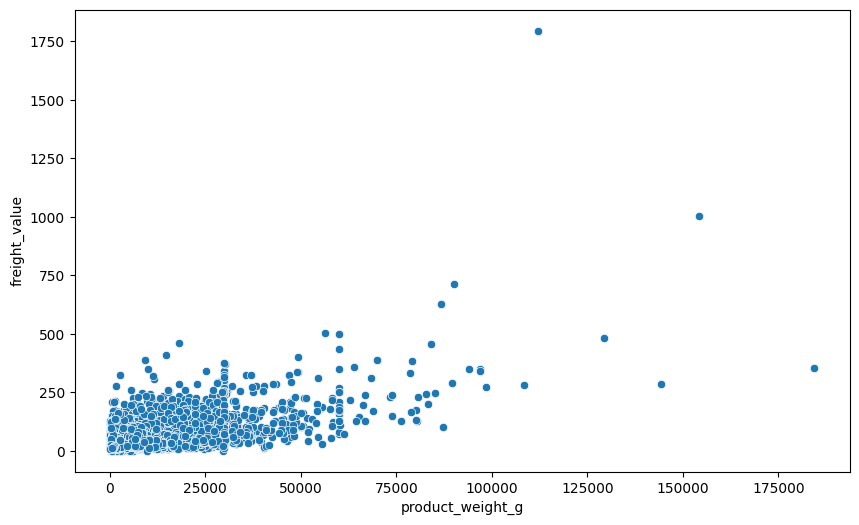

In [27]:
plot_freight_value_weight_relationship(freight_value_weight_relationship)

The Freight Value and Weight Relationship plot you will code in src/plots.py has to be similar to this:

![The plot you will code will be similar to this:](images/freight_value_weight_relationship.png "Freight Value and Weight Relationship")

4.2 Do you see any correlation between the freight value and the product weight?

### Yes, there is a slight linear relationship. Where as the weight of the product increases, the freight value increases. Keep in mind that there are some outliers to review.